In [1]:
import glob
import os
import json
import pickle
import yaml
import math

import uproot

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'had': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [4]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return round(lum_)

years = ["2018", "2017", "2016", "2016APV"]
channels = ["ele", "mu"]
get_lumi(years ,channels)

138

# Hist

In [5]:
! ls ../combine/templates/qcd_scale

hists_templates_2017.pkl


In [6]:
# get lumi
import pickle as pkl
with open("../combine/templates/qcd_scale/hists_templates_2017.pkl", "rb") as f:
    h = pkl.load(f)

In [7]:
h

Hist(
  StrCategory(['VBF', 'WH', 'WJetsLNu', 'TTbar', 'SingleTop', 'ggF', 'ttH', 'ZH'], growth=True, name='Sample'),
  StrCategory(['nominal', 'weight_qcd_scale_up', 'weight_qcd_scale_down'], growth=True, name='Systematic'),
  StrCategory(['VBFcat', 'ggFcat', 'TopCR', 'WJetsCR'], growth=True, name='Region'),
  Variable([55, 75, 95, 115, 135, 155, 175, 195, 215, 235], name='mass_observable', label='Higgs reconstructed mass [GeV]'),
  storage=Weight()) # Sum: WeightedSum(value=8822.4, variance=2185.92) (WeightedSum(value=9655.15, variance=2319.27) with flow)

/Users/fmokhtar/miniconda3/envs/coffea-env/lib/python3.9/site-packages/hist/basehist.py:400: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


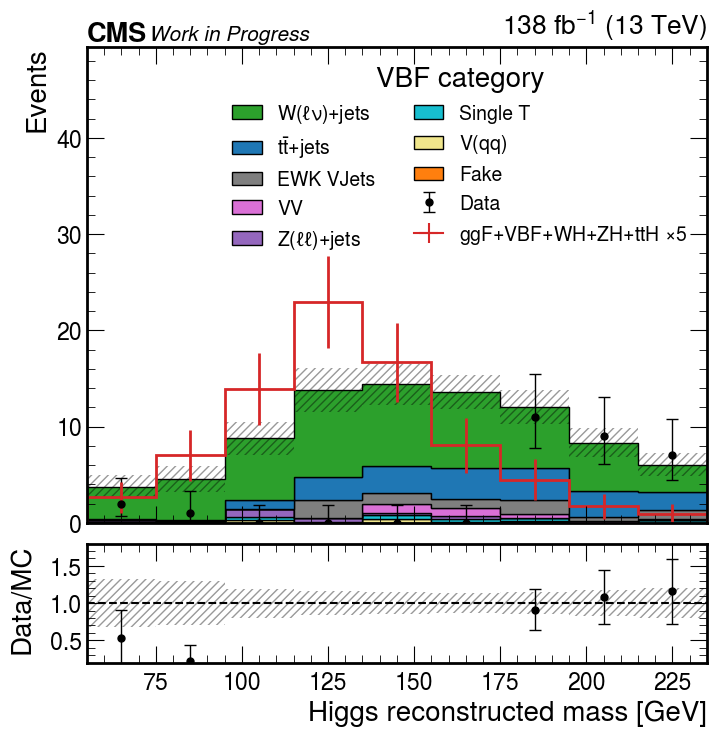

In [40]:
# systematic = "JMS_2018_down"
systematic = "nominal"

region = "VBF92and500and35"
text = "VBF category"

# region = "ggFpt250to350"
# text = r"ggF $p_T$ $\in$ [250, 350]"

# region = "ggFpt350to500"
# text = r"ggF $p_T$ $\in$ [350, 500]"

# region = "ggFpt500toInf"
# text = r"ggF $p_T$ $\in$ [500, Inf]"

# region = "TopCR"
# text = "Top control region"

# region = "WJetsCR"
# text = "WJets control region"

plt.rcParams.update({"font.size": 20})
add_data = True

# if region.startswith("SR"):
add_soverb=True
blind_region=[100,160]
if "VBF" in region:
    mult=5
else:
    mult=10
# else:
#     add_soverb=True
#     blind_region=None
#     blind_region=[90,160]
#     mult=1

if "CR" in region:
    blind_region = False
    mult=1

years = ["2018", "2017", "2016", "2016APV"]
channels = ["ele", "mu"]

from utilsCombine import plot_hists
from utilsCombine2 import plot_hists

# samples = list(h.axes["Sample"])
# samples.remove("ggFpt200to300")
# samples.remove("ggFpt300to450")
# samples.remove("ggFpt450toInf")

plot_hists(h[{"Sample": samples, "Systematic": systematic, "Region": region}], years, channels,
            add_data=add_data,
            logy=False,
            add_soverb=add_soverb,
            only_sig=False,
            mult=mult,
            outpath=f"/Users/fmokhtar/Desktop/AN_2024/combine/v6/",
           save_as=region,
           text_=text,
            blind_region=blind_region,
#            remove_samples=["WH", "ZH", "ttH"],
          )


max 6.76%
min 6.88%
-------------------------------


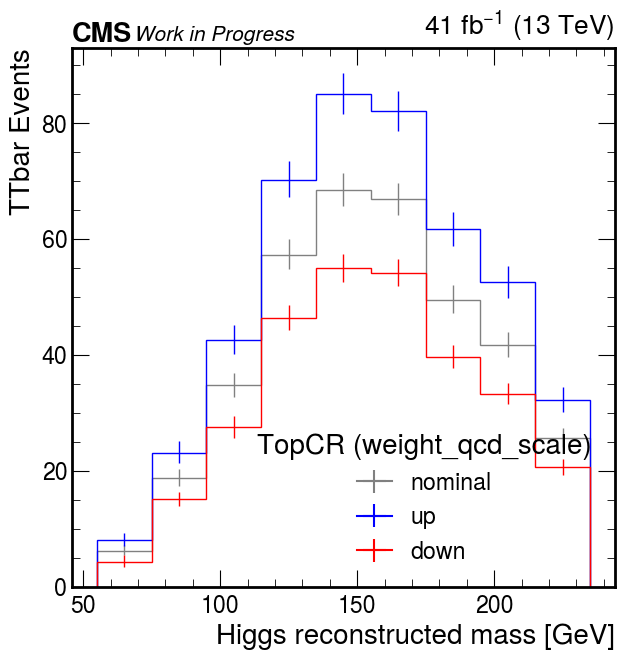

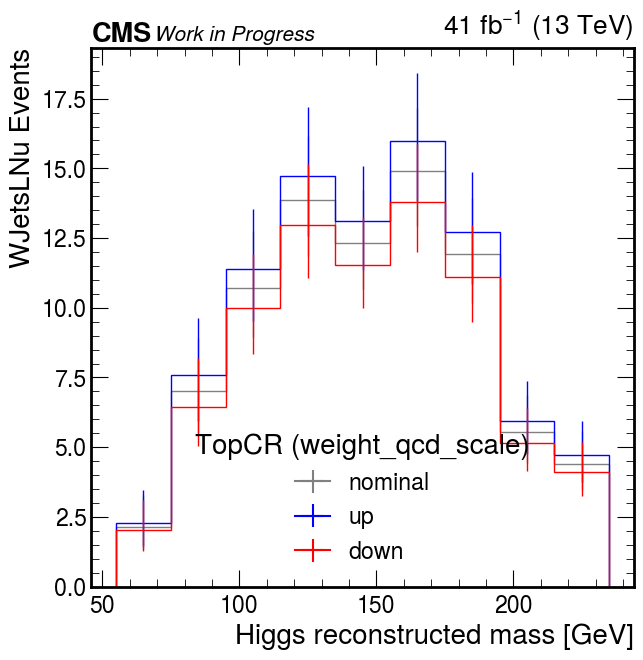

In [16]:
color_dict = {
    "Nominal": "grey",
    "Up": "blue",
    "Down": "red",
}

label_dict = {
    "nominal": "Nominal",
    "up": "Up",
    "down": "Down",    
}


CMS_PARAMS_LABEL = "CMS_HWW_boosted"
syst_dict = {
    "weight_qcd_scale": "QCDScaleacc unc.",
    "weight_pdf_acceptance": "PDFacc unc.",
    "weight_btagSFbcCorrelated": "btagSFbcCorrelated unc.",
    "weight_btagSFlightCorrelated": "btagSFlightCorrelated unc.",
    "weight_pileup_2016APV": "PU unc. 2016APV",
    "weight_pileup_2016": "PU unc. 2016",
    "weight_pileup_2017": "PU unc. 2017",
    "weight_pileup_2018": "PU unc. 2018",
    "weight_pileup_id": "PU ID unc.",
    "UES": "Unclustered energy unc.",
    "weight_L1Prefiring_2016APV": "L1 ecal prefiring (2016APV)",
    "weight_L1Prefiring_2016": "L1 ecal prefiring (2016)",
    "weight_L1Prefiring_2017": "L1 ecal prefiring (2017)",
    "weight_PSFSR": "PS FSR",
    "weight_mu_id": f"{CMS_PARAMS_LABEL}_mu_identification",
    "weight_ele_id": f"{CMS_PARAMS_LABEL}_ele_identification",
    "weight_ele_reco": f"{CMS_PARAMS_LABEL}_ele_reconstruction",
    
}

years = ["2018", "2017", "2016", "2016APV"]
channels = ["ele", "mu"]

region = "ggFpt250to350"
region = "TopCR"


for systematic in [
    "weight_qcd_scale",
#     "weight_pdf_acceptance", 
#     "weight_PSISR",
#     "weight_PSFSR",
#     "weight_btagSFbcCorrelated", 
#     "weight_btagSFlightCorrelated",
#     "weight_pileup_2016APV",
#     "weight_pileup_2016",
#     "weight_pileup_2017",
#     "weight_pileup_2018", 
#     "weight_pileup_id",
    
#     "JMS_2017",
    
#     "UES",
#     "weight_L1Prefiring_2016APV",
#     "weight_L1Prefiring_2016",
#     "weight_L1Prefiring_2017",
#     "weight_PSFSR",
#     "weight_ele_id",
#     "weight_ele_reco",
#     "weight_mu_id",
#     "trigger_ele_SF",
#     "weight_TopPtReweight"
    
]:
    
    max_ = 0
    min_ = 0     
    for sample in [
#         "SingleTop",
        "TTbar",
        "WJetsLNu",
#         "ggF",
#         "VBF",
#         "WH",
#         "ZH",
#         "EWKvjets",
#         "ttH",
    ]:
        max_ = 0
        min_ = 0  
        fig, ax = plt.subplots(figsize=(7,7))
    
        sum_envelope = {}
        for variation in ["nominal", "up", "down"]:

            syst = variation if variation == "nominal" else f"{systematic}_{variation}"

            hep.histplot(
                h[{"Sample": sample, "Region": region, "Systematic": syst}],
                ax=ax,
                linewidth=1,
                histtype="step",
                label=variation,#label_dict[variation],
                flow="none",
                color=color_dict[label_dict[variation]]
            )

            sum_envelope[variation] = h[{"Sample": sample, "Region": region, "Systematic": syst}].values().sum()

#         ax.legend(title=sample + f" ({syst_dict[systematic]})")
        ax.legend(title=region + f" ({systematic})")        

        ax.set_ylabel(f"{sample} Events")
        # ax.set_ylim(0)
        # ax.set_yscale("log")

#         print(sample, syst_dict[systematic], f" nominal + {100*abs(1-sum_envelope['up']/sum_envelope['nominal']):.2f}% - {100*abs(1-sum_envelope['down']/sum_envelope['nominal']):.2f}%")

        upsie = 100*abs(1-sum_envelope['up']/sum_envelope['nominal'])
        max_ = upsie if max_<upsie else max_
        
        downsie = 100*abs(1-sum_envelope['down']/sum_envelope['nominal'])        
        min_ = downsie if min_<downsie else min_

        hep.cms.lumitext(str(get_lumi(["2017"], channels)) + r" fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
        hep.cms.text("Work in Progress", ax=ax, fontsize=15)
        
        plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/systematics/{region}_{systematic}_{sample}.pdf")
    
    print()
    print(f"max {max_:.2f}%")
    print(f"min {min_:.2f}%")    
    print("-------------------------------")        

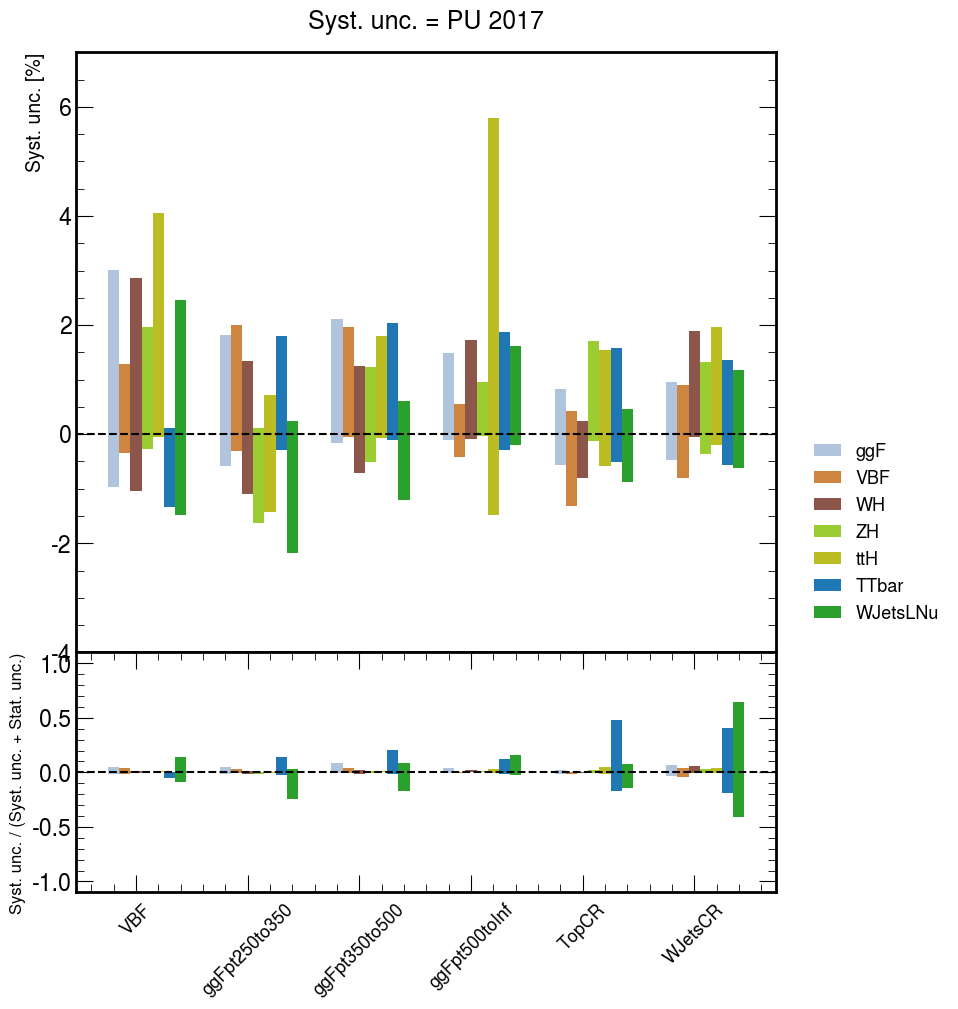

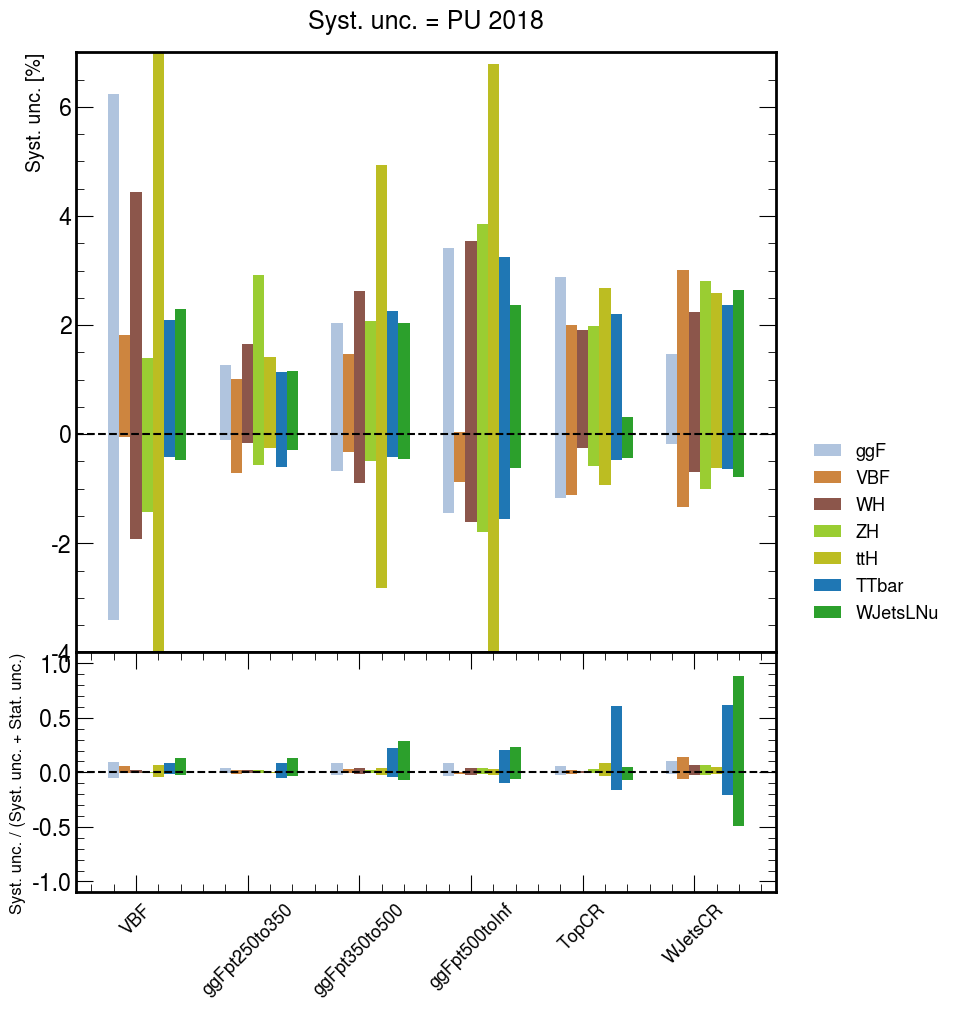

In [11]:
color_by_sample = {
    "ggF": "lightsteelblue",
    "VBF": "peru",
    # signal that is background
    "WH": "tab:brown",
    "ZH": "yellowgreen",
    "ttH": "tab:olive",
    # background
    "QCD": "tab:orange",
    "Fake": "tab:orange",
    "WJetsLNu": "tab:green",
    "TTbar": "tab:blue",
    "Diboson": "orchid",
    "SingleTop": "tab:cyan",
    "EWKvjets": "tab:grey",
    "DYJets": "tab:purple",
    "WZQQ": "khaki",
    # "WZQQorDYJets": "khaki",
    # wjets matched and unmatched
    "WJetsLNu_unmatched": "lightgreen",
    "WJetsLNu_matched": "tab:green",
    # ttbar matched and unmatched
    "TTbar_allmatched": "tab:blue",
    "TTbar_unmatched": "lightskyblue",
    "TTbar_LP": "lightskyblue",
}

CMS_PARAMS_LABEL = "CMS_HWW_boosted"
syst_dict = {
    
    "weight_qcd_scale": "QCD scale acceptance",
    "weight_pdf_acceptance": "PDF acceptance",
    ################## btag    
    "weight_btagSFbcCorrelated": "btagSFbcCorrelated",
    "weight_btagSFlightCorrelated": "btagSFlightCorrelated",

    "weight_btagSFlight_2016APV": "btagSFlight (2016APV)",
    "weight_btagSFlight_2016": "btagSFlight (2016)",
    "weight_btagSFlight_2017": "btagSFlight (2017)",
    "weight_btagSFlight_2018": "btagSFlight (2018)",    

    "weight_btagSFbc_2016APV": "btagSFbc (2016APV)",
    "weight_btagSFbc_2016": "btagSFbc (2016)",
    "weight_btagSFbc_2017": "btagSFbc (2017)",
    "weight_btagSFbc_2018": "btagSFbc (2018)",    

    ################## common
    "weight_PSFSR": "PS FSR",
    "weight_PSISR": "PS ISR",
    "weight_pileup_id": "PU Jet ID",
    "weight_pileup_2016APV": "PU unc. 2016APV",
    "weight_pileup_2016": "PU 2016",
    "weight_pileup_2017": "PU 2017",
    "weight_pileup_2018": "PU 2018",
    "weight_L1Prefiring_2016APV": "L1 ecal prefiring (2016APV)",
    "weight_L1Prefiring_2016": "L1 ecal prefiring (2016)",
    "weight_L1Prefiring_2017": "L1 ecal prefiring (2017)",
    "weight_mu_id_stat": f"{CMS_PARAMS_LABEL}_mu_identification_stat",
    "weight_mu_id_syst": f"{CMS_PARAMS_LABEL}_mu_identification_syst",    
    "weight_ele_id": f"{CMS_PARAMS_LABEL}_ele_identification",
    "weight_ele_reco": f"{CMS_PARAMS_LABEL}_ele_reconstruction",
    "weight_ele_isolation": f"{CMS_PARAMS_LABEL}_ele_isolation",
    "weight_mu_isolation": f"{CMS_PARAMS_LABEL}_mu_isolation",
    "weight_ele_trigger": f"{CMS_PARAMS_LABEL}_ele_trigger",
    "weight_mu_trigger_noniso": f"{CMS_PARAMS_LABEL}_mu_trigger",
    "weight_mu_trigger_iso": f"{CMS_PARAMS_LABEL}_mu_trigger_iso",   
    
    "trigger_ele_SF": f"{CMS_PARAMS_LABEL}_ele_trigger",
    
    ################## JECs corr
    "UES": "Unclustered energy",
    "JES_FlavorQCD": "CMS_scale_j_FlavQCD",
    "JES_RelativeBal": "CMS_scale_j_RelBal",
    "JES_HF": "CMS_scale_j_HF",
    "JES_BBEC1": "CMS_scale_j_BBEC1",
    "JES_EC2": "CMS_scale_j_EC2",
    "JES_Absolute": "CMS_scale_j_Abs",
    
    ################## JECs uncorr
    "JES_BBEC1_2016APV": "CMS_scale_j_BBEC1_2016APV",
    "JES_BBEC1_2016": "CMS_scale_j_BBEC1_2016",
    "JES_BBEC1_2017": "CMS_scale_j_BBEC1_2017",
    "JES_BBEC1_2018": "CMS_scale_j_BBEC1_2018",
    
    "JES_RelativeSample_2016APV": "CMS_scale_j_RelSample_2016APV",
    "JES_RelativeSample_2016": "CMS_scale_j_RelSample_2016",
    "JES_RelativeSample_2017": "CMS_scale_j_RelSample_2017",
    "JES_RelativeSample_2018": "CMS_scale_j_RelSample_2018",
    
    "JES_HF_2016APV": "CMS_scale_j_HF_2016APV",
    "JES_HF_2016": "CMS_scale_j_HF_2016",
    "JES_HF_2017": "CMS_scale_j_HF_2017",
    "JES_HF_2018": "CMS_scale_j_HF_2018",    
    
    "JES_EC2_2016APV": "CMS_scale_j_EC2_2016APV",
    "JES_EC2_2016": "CMS_scale_j_EC2_2016",
    "JES_EC2_2017": "CMS_scale_j_EC2_2017",
    "JES_EC2_2018": "CMS_scale_j_EC2_2018",    
    
    "JES_Absolute_2016APV": "CMS_scale_j_Abs_2016APV",
    "JES_Absolute_2016": "CMS_scale_j_Abs_2016",
    "JES_Absolute_2017": "CMS_scale_j_Abs_2017",
    "JES_Absolute_2018": "CMS_scale_j_Abs_2018",        
    
    "JMS_2016APV": "CMS_jms_2016APV",
    "JMS_2016": "CMS_jms_2016",
    "JMS_2017": "CMS_jms_2017",
    "JMS_2018": "CMS_jms_2018",

    "JMR_2016APV": "CMS_jmr_2016APV",
    "JMR_2016": "CMS_jmr_2016",
    "JMR_2017": "CMS_jmr_2017",
    "JMR_2018": "CMS_jmr_2018",   

    "JER_2016APV": "CMS_res_j_2016APV",
    "JER_2016": "CMS_res_j_2016",
    "JER_2017": "CMS_res_j_2017",
    "JER_2018": "CMS_res_j_2018",       
    
}


regions = [
#     "Pre-selection",
    "VBF",
    "ggFpt250to350",
    "ggFpt350to500",
    "ggFpt500toInf",    
    "TopCR",
    "WJetsCR",
]
samples = [
    "ggF", 
    "VBF", 
    "WH", 
    "ZH", 
    "ttH",
    "TTbar",
    "WJetsLNu",
]
sigs = [
    "ggF", 
    "VBF", 
    "WH", 
    "ZH", 
    "ttH",
]

for systematic in [
#     "weight_pdf_acceptance", 
#     "weight_PSFSR",
#     "weight_PSISR",
#     "weight_qcd_scale",
#     ################# btag
#     "weight_btagSFbcCorrelated", 
#     "weight_btagSFlightCorrelated",
#     "weight_btagSFlight_2016APV",
#     "weight_btagSFlight_2016",
#     "weight_btagSFlight_2017",
#     "weight_btagSFlight_2018",
#     "weight_btagSFbc_2016APV",
#     "weight_btagSFbc_2016",
#     "weight_btagSFbc_2017",
#     "weight_btagSFbc_2018",    
#     ################## common

#     "weight_pileup_id",
#     "weight_pileup_2016APV",
#     "weight_pileup_2016",
    "weight_pileup_2017",
    "weight_pileup_2018", 
#     "weight_pileup_id",
#     "weight_L1Prefiring_2016APV",
#     "weight_L1Prefiring_2016",
#     "weight_L1Prefiring_2017",
#     "weight_PSFSR",
#     "weight_ele_id",
#     "weight_ele_reco",    
#     "weight_mu_id_syst",
#     "weight_mu_id_stat",
#     "weight_mu_isolation",
#     "trigger_ele_SF",
#     "weight_mu_trigger_noniso",
#     "weight_mu_trigger_iso",    
#     ################# JECs correlated   
#      "UES",
#      "JES_FlavorQCD",
#      "JES_RelativeBal",
#      "JES_HF",
#      "JES_BBEC1",
#      "JES_EC2",
#      "JES_Absolute",

# #     ################# JECs uncorrelated  
#     "JES_BBEC1_2016APV",
#     "JES_BBEC1_2016",
#     "JES_BBEC1_2017",
#     "JES_BBEC1_2018",    
#     "JES_RelativeSample_2016APV",
#     "JES_RelativeSample_2016",
#     "JES_RelativeSample_2017",
#     "JES_RelativeSample_2018",    
#     "JES_EC2_2016APV",
#     "JES_EC2_2016",
#     "JES_EC2_2017",
#     "JES_EC2_2018",    
#     "JES_HF_2016APV",
#     "JES_HF_2016",
#     "JES_HF_2017",
#     "JES_HF_2018",    
#     "JES_Absolute_2016APV",
#     "JES_Absolute_2016",
#     "JES_Absolute_2017",
#     "JES_Absolute_2018",
    
#     "JMS_2016APV",
#     "JMS_2016",
#     "JMS_2017",
#     "JMS_2018",

#     "JMR_2016APV",
#     "JMR_2016",
#     "JMR_2017",
#     "JMR_2018",   

#     "JER_2016APV",
#     "JER_2016",
#     "JER_2017",
#     "JER_2018",
]:

    bar_width = 0.1

    # Create a figure with two subplots: larger upper subplot and smaller lower subplot
    fig = plt.figure(figsize=(10, 12))

    # Define two subplots: the first one takes more space, the second one is smaller
    ax1 = fig.add_axes([0.1, 0.4, 0.7, 0.5])  # Main plot (relative syst unc)
    ax2 = fig.add_axes([0.1, 0.2, 0.7, 0.2])  # Smaller plot (rel_sys_unc/total_unc)
    
    for iregion, region in enumerate(regions):

        for i, sample in enumerate(samples):

            # Get the nominal yield and calculate stat uncertainty
            nominal_yield = h[{"Sample": sample, "Region": region, "Systematic": "nominal"}].values().sum()
            stat_unc = np.sqrt(nominal_yield)
            rel_stat_unc = stat_unc / nominal_yield

            # First plot (relative syst unc): this is the main plot now
            up_yield = h[{"Sample": sample, "Region": region, "Systematic": f"{systematic}_up"}].values().sum()
            rel_sys_unc_up = abs(up_yield/nominal_yield-1)
            bars = ax1.bar(iregion + i * bar_width, 100 * rel_sys_unc_up, bar_width, label=sample, color=color_by_sample[sample])

            down_yield = h[{"Sample": sample, "Region": region, "Systematic": f"{systematic}_down"}].values().sum()
            rel_sys_unc_down = abs(down_yield / nominal_yield - 1)
            bars = ax1.bar(iregion + i * bar_width, -100 * rel_sys_unc_down, bar_width, color=color_by_sample[sample])

            # Second plot (rel_sys_unc/total_unc): smaller subplot
            total_unc_up = np.sqrt(rel_stat_unc**2 + rel_sys_unc_up**2)
            total_unc_down = np.sqrt(rel_stat_unc**2 + rel_sys_unc_down**2)
            
            X_up = rel_sys_unc_up / total_unc_up
            bars = ax2.bar(iregion + i * bar_width, X_up, bar_width, label=sample, color=color_by_sample[sample])

            X_down = rel_sys_unc_down / total_unc_down
            bars = ax2.bar(iregion + i * bar_width, -X_down, bar_width, color=color_by_sample[sample])

            

    # Adjust x-tick labels to match the number of regions for both subplots
    ax1.set_xticks([])
    ax2.set_xticks(np.arange(len(regions)) + bar_width * 2)
    ax2.set_xticklabels(regions, rotation=45, fontsize=13)

    # Single legend outside both plots, centered
    handles, labels = ax1.get_legend_handles_labels()[0][:len(samples)], ax1.get_legend_handles_labels()[1][:len(samples)]
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.82, 0.5), fontsize=13)

    # Set titles and labels
    ax1.set_title(f"Syst. unc. = {syst_dict[systematic]}", pad=17, fontsize=18)
    ax1.set_ylabel(f"Syst. unc. [%]", fontsize=14)

    # Set ylabel for the smaller subplot
    ax2.set_ylabel(f"Syst. unc. / (Syst. unc. + Stat. unc.)", fontsize=12)
    
    ax1.axhline(y=0, color='black', linestyle='--')
    ax2.axhline(y=0, color='black', linestyle='--')
    
    ax2.set_ylim(-1.1,1.1)
    
    ax1.set_ylim(-4,7)
    
#     plt.tight_layout()
    plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/systematics/{systematic}.pdf")

In [ ]:
h[{"Sample": "ggF", "Region": "TopCR", "Systematic": "weight_pileup_id_up"}].values()

In [944]:
h[{"Sample": "ggF", "Region": "TopCR", "Systematic": "nominal"}].values()

array([0.46700449, 0.95111955, 1.30249873, 1.66295344, 1.01031232,
       0.63017791, 0.45858901, 0.38646449, 0.09048372])

In [945]:
h[{"Sample": "ggF", "Region": "TopCR", "Systematic": "weight_pileup_id_down"}].values()

array([0.46739851, 0.94677764, 1.27977389, 1.6456897 , 1.00674046,
       0.62838933, 0.45786581, 0.39883803, 0.09206157])

In [15]:
h

Hist(
  StrCategory(['VBF', 'Data', 'EWKvjets', 'WH', 'WJetsLNu', 'TTbar', 'SingleTop', 'ggFpt200to300', 'ggFpt300to450', 'ggFpt450toInf', 'ggF', 'DYJets', 'Diboson', 'WZQQ', 'ttH', 'ZH', 'Fake'], growth=True, name='Sample'),
  StrCategory(['nominal', 'trigger_ele_SF_up', 'trigger_ele_SF_down', 'weight_pdf_acceptance_up', 'weight_pdf_acceptance_down', 'weight_qcd_scale_up', 'weight_qcd_scale_down', 'top_reweighting_up', 'top_reweighting_down', 'weight_pileup_id_up', 'weight_pileup_id_down', 'weight_PSFSR_up', 'weight_PSFSR_down', 'weight_PSISR_up', 'weight_PSISR_down', 'weight_d1K_NLO_up', 'weight_d1K_NLO_down', 'weight_d2K_NLO_up', 'weight_d2K_NLO_down', 'weight_d3K_NLO_up', 'weight_d3K_NLO_down', 'weight_d1kappa_EW_up', 'weight_d1kappa_EW_down', 'weight_W_d2kappa_EW_up', 'weight_W_d2kappa_EW_down', 'weight_W_d3kappa_EW_up', 'weight_W_d3kappa_EW_down', 'weight_Z_d2kappa_EW_up', 'weight_Z_d2kappa_EW_down', 'weight_Z_d3kappa_EW_up', 'weight_Z_d3kappa_EW_down', 'weight_ele_id_up', 'weigh


max 1.82%
min 0.58%
-------------------------------


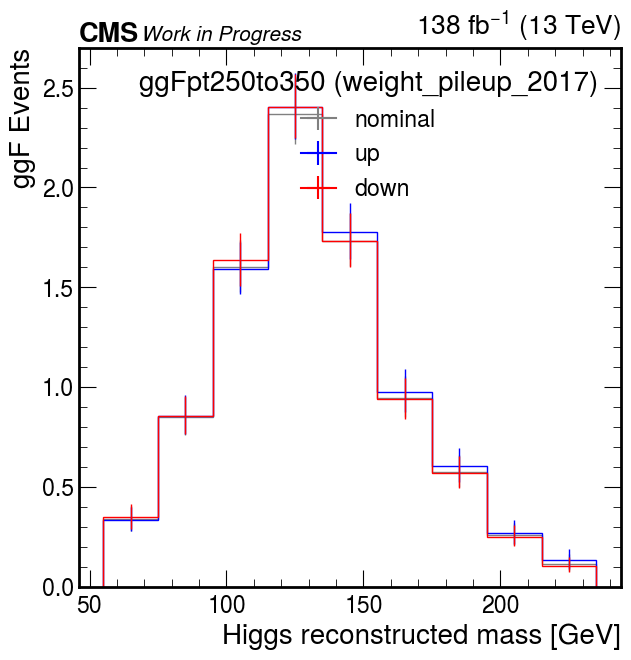

In [15]:
color_dict = {
    "Nominal": "grey",
    "Up": "blue",
    "Down": "red",
}

label_dict = {
    "nominal": "Nominal",
    "up": "Up",
    "down": "Down",    
}


CMS_PARAMS_LABEL = "CMS_HWW_boosted"
syst_dict = {
    "weight_qcd_scale": "QCDScaleacc unc.",
    "weight_pdf_acceptance": "PDFacc unc.",
    "weight_btagSFbcCorrelated": "btagSFbcCorrelated unc.",
    "weight_btagSFlightCorrelated": "btagSFlightCorrelated unc.",
    "weight_pileup_2016APV": "PU unc. 2016APV",
    "weight_pileup_2016": "PU unc. 2016",
    "weight_pileup_2017": "PU unc. 2017",
    "weight_pileup_2018": "PU unc. 2018",
    "weight_pileup_id": "PU ID unc.",
    "UES": "Unclustered energy unc.",
    "weight_L1Prefiring_2016APV": "L1 ecal prefiring (2016APV)",
    "weight_L1Prefiring_2016": "L1 ecal prefiring (2016)",
    "weight_L1Prefiring_2017": "L1 ecal prefiring (2017)",
    "weight_PSFSR": "PS FSR",
    "weight_mu_id": f"{CMS_PARAMS_LABEL}_mu_identification",
    "weight_ele_id": f"{CMS_PARAMS_LABEL}_ele_identification",
    "weight_ele_reco": f"{CMS_PARAMS_LABEL}_ele_reconstruction",
    
}

years = ["2018", "2017", "2016", "2016APV"]
channels = ["ele", "mu"]

region = "ggFpt250to350"
for systematic in [
#     "weight_qcd_scale", 
#     "weight_pdf_acceptance", 
#     "weight_btagSFbcCorrelated", 
#     "weight_btagSFlightCorrelated",
#     "weight_pileup_2016APV",
#     "weight_pileup_2016",
    "weight_pileup_2017",
#     "weight_pileup_2018", 
#     "weight_pileup_id",
    
#     "JMS_2017",
    
#     "UES",
#     "weight_L1Prefiring_2016APV",
#     "weight_L1Prefiring_2016",
#     "weight_L1Prefiring_2017",
#     "weight_PSFSR",
#     "weight_ele_id",
#     "weight_ele_reco",    
#     "weight_mu_id",
]:
    
    max_ = 0
    min_ = 0     
    for sample in [
#         "TTbar", 
#         "WJetsLNu", 
        "ggF", 
#         "VBF", 
#         "WH", 
#         "ZH", 
#         "EWKvjets",
    ]:

        fig, ax = plt.subplots(figsize=(7,7))
    
        sum_envelope = {}
        for variation in ["nominal", "up", "down"]:

            syst = variation if variation == "nominal" else f"{systematic}_{variation}"

            hep.histplot(
                h[{"Sample": sample, "Region": region, "Systematic": syst}],
                ax=ax,
                linewidth=1,
                histtype="step",
                label=variation,#label_dict[variation],
                flow="none",
                color=color_dict[label_dict[variation]]
            )

            sum_envelope[variation] = h[{"Sample": sample, "Region": region, "Systematic": syst}].values().sum()

#         ax.legend(title=sample + f" ({syst_dict[systematic]})")
        ax.legend(title=region + f" ({systematic})")        

        ax.set_ylabel(f"{sample} Events")
        # ax.set_ylim(0)
        # ax.set_yscale("log")

#         print(sample, syst_dict[systematic], f" nominal + {100*abs(1-sum_envelope['up']/sum_envelope['nominal']):.2f}% - {100*abs(1-sum_envelope['down']/sum_envelope['nominal']):.2f}%")

        upsie = 100*abs(1-sum_envelope['up']/sum_envelope['nominal'])
        max_ = upsie if max_<upsie else max_
        
        downsie = 100*abs(1-sum_envelope['down']/sum_envelope['nominal'])        
        min_ = downsie if min_<downsie else min_

        hep.cms.lumitext(str(get_lumi(years, channels)) + r" fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
        hep.cms.text("Work in Progress", ax=ax, fontsize=15)
        
        plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/systematics/{region}_{systematic}_{sample}.pdf")
    
    print()
    print(f"max {max_:.2f}%")
    print(f"min {min_:.2f}%")    
    print("-------------------------------")        


max 1202.90%
min 1192.29%
-------------------------------

max 1202.90%
min 1192.29%
-------------------------------


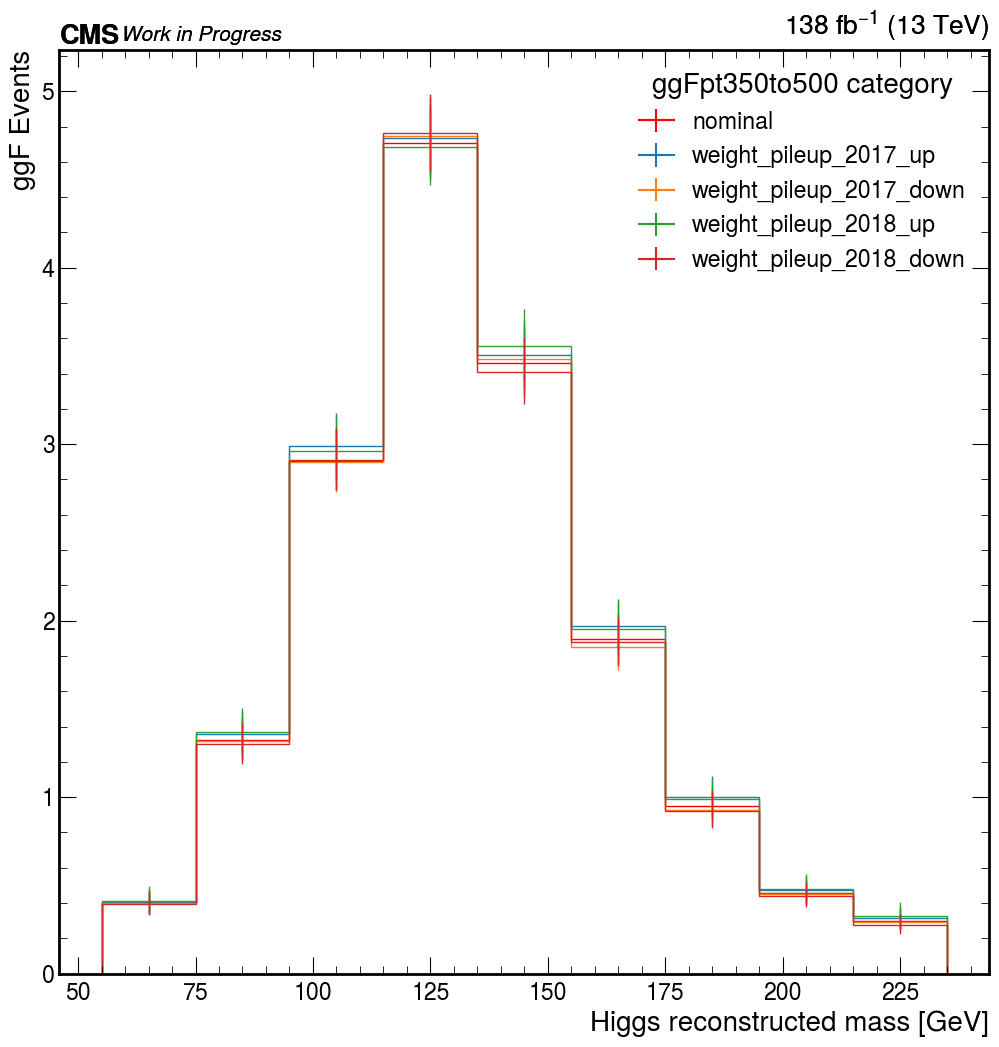

In [29]:
color_dict = {
    "Nominal": "grey",
    "Up": "blue",
    "Down": "red",
}

label_dict = {
    "nominal": "Nominal",
    "up": "Up",
    "down": "Down",    
}


CMS_PARAMS_LABEL = "CMS_HWW_boosted"
syst_dict = {
    "weight_qcd_scale": "QCDScaleacc unc.",
    "weight_pdf_acceptance": "PDFacc unc.",
    "weight_btagSFbcCorrelated": "btagSFbcCorrelated unc.",
    "weight_btagSFlightCorrelated": "btagSFlightCorrelated unc.",
    "weight_pileup_2016APV": "PU unc. 2016APV",
    "weight_pileup_2016": "PU unc. 2016",
    "weight_pileup_2017": "PU unc. 2017",
    "weight_pileup_2018": "PU unc. 2018",
    "weight_pileup_id": "PU ID unc.",
    "UES": "Unclustered energy unc.",
    "weight_L1Prefiring_2016APV": "L1 ecal prefiring (2016APV)",
    "weight_L1Prefiring_2016": "L1 ecal prefiring (2016)",
    "weight_L1Prefiring_2017": "L1 ecal prefiring (2017)",
    "weight_PSFSR": "PS FSR",
    "weight_mu_id": f"{CMS_PARAMS_LABEL}_mu_identification",
    "weight_ele_id": f"{CMS_PARAMS_LABEL}_ele_identification",
    "weight_ele_reco": f"{CMS_PARAMS_LABEL}_ele_reconstruction",
    
}
sample = "ggF"

years = ["2018", "2017", "2016", "2016APV"]
channels = ["ele", "mu"]

region = "ggFpt350to500"

fig, ax = plt.subplots(figsize=(12,12))

sum_envelope = {}
syst = "nominal"

hep.histplot(
    h[{"Sample": sample, "Region": region, "Systematic": syst}],
    ax=ax,
    linewidth=1,
    histtype="step",
    label="nominal",#label_dict[variation],
    flow="none",
    color=color_dict[label_dict[variation]]
)
sum_envelope["nominal"] = h[{"Sample": sample, "Region": region, "Systematic": syst}].values().sum()

for systematic in [
    "weight_pileup_2017",
    "weight_pileup_2018",
]:


    for variation in ["up", "down"]:

        syst = variation if variation == "nominal" else f"{systematic}_{variation}"

        hep.histplot(
            h[{"Sample": sample, "Region": region, "Systematic": syst}],
            ax=ax,
            linewidth=1,
            histtype="step",
            label=f"{systematic}_{variation}",#label_dict[variation],
            flow="none",
#                 color=color_dict[label_dict[variation]]
        )

        sum_envelope[variation] = h[{"Sample": sample, "Region": region, "Systematic": syst}].values().sum()

#         ax.legend(title=sample + f" ({syst_dict[systematic]})")
    ax.legend(title=region + " category")

    ax.set_ylabel(f"{sample} Events")
    # ax.set_ylim(0)
    # ax.set_yscale("log")

#         print(sample, syst_dict[systematic], f" nominal + {100*abs(1-sum_envelope['up']/sum_envelope['nominal']):.2f}% - {100*abs(1-sum_envelope['down']/sum_envelope['nominal']):.2f}%")

    upsie = 100*abs(1-sum_envelope['up']/sum_envelope['nominal'])
    max_ = upsie if max_<upsie else max_

    downsie = 100*abs(1-sum_envelope['down']/sum_envelope['nominal'])        
    min_ = downsie if min_<downsie else min_

    hep.cms.lumitext(str(get_lumi(years, channels)) + r" fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
    hep.cms.text("Work in Progress", ax=ax, fontsize=15)

#     plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/systematics/{region}_{systematic}_{sample}.pdf")

    print()
    print(f"max {max_:.2f}%")
    print(f"min {min_:.2f}%")    
    print("-------------------------------")        

# Post-fit stacked plots

In [25]:
samples_dict = {
    "data": "Data",
    
    "ggH_hww": "ggF",    
    "qqH_hww": "VBF",
    "WH_hww": "WH",
    "ZH_hww": "ZH",
    "ttH_hww": "ttH",
    
    "diboson": "Diboson",
    "ewkvjets": "EWKvjets",
    "singletop": "SingleTop",
    "qcd": "QCD",
    "ttbar": "TTbar",
    "wjets": "WJetsLNu",
    "wzqq": "WZQQ",    
    "zjets": "DYJets",      
    "vjets": "WZQQorDYJets",
    
    "fake": "Fake",    
    
}

region_dict = {
    "SR1": "VBF category",
    "SR2": r"ggF $p_T$ $\in$ [250, 350]",
    "SR3": r"ggF $p_T$ $\in$ [350, 500]",
    "SR4": r"ggF $p_T$ $\in$ [500, Inf]",

    "CR1": "Top control region",
    "CR2": "WJets control region",
}

region_dict_h = {
    "SR1": "VBF",
    "SR2": "ggFpt250to300",
    "SR3": "ggFpt300to450",
    "SR4": "ggFpt450to650",
    "SR5": "ggFpt650toInf",
    
    "CR1": "TopCR",
    "CR2": "WJetsCR",
}


add_back_MC=False

f = uproot.open("/Users/fmokhtar/Desktop/AN_2024/combine/v9/asimov_sb/fitDiagnosticsAsimov.root")

In [26]:
massbinwidth = {
    "SR1": 20,
    "SR2": 20,
    "SR3": 20,
    "SR4": 20,
    "SR5": 20,    
    "CR1": 20,
    "CR2": 20,
}

def plot_(key="shapes_fit_s", region="SR1", mult=1):

    ######################
    nbins = len(list(range(55, 255, massbinwidth[region])))-1
    samples = [samples_dict[sample[:-2]] for sample in f[f"{key}/{region}"].keys() if "total" not in sample]

    hf = hist2.Hist(
        hist2.axis.StrCategory(samples, name="Sample", growth=True),    
        hist2.axis.Regular(nbins, 55, 235, name="var", label=r"Higgs reconstructed mass [GeV]"),
    #     storage=hist2.storage.Weight(),
    )


    for sample in  f[f"{key}/{region}"].keys():
        if "total" in sample:
            continue

        smpl = samples_dict[sample[:-2]] # there's an additional ";1" that must be removed

        if "data" in sample:
            X = f[f"{key}/{region}"][sample].values()[1]*massbinwidth[region]
        else:
            X = f[f"{key}/{region}"][sample].values()*massbinwidth[region]

        hf[{"Sample": smpl}] = X


    plt.rcParams.update({"font.size": 20})

    years = ["2018", "2017", "2016", "2016APV"]
    channels = ["ele", "mu"]

    add_data = True
    from utilsCombine4 import plot_hists
    plot_hists(hf, years, channels,
                add_data=add_data,
                logy=False,
                add_soverb=False,
                only_sig=False,
                mult=mult,
                outpath=f"/Users/fmokhtar/Desktop/AN_2024/combine/v9/asimov_sb/",
               save_as=f"{key}_{region}",
               text_=region_dict[region],
               blind_region=False,
               remove_samples=["ttH", "WH", "ZH"]
              )

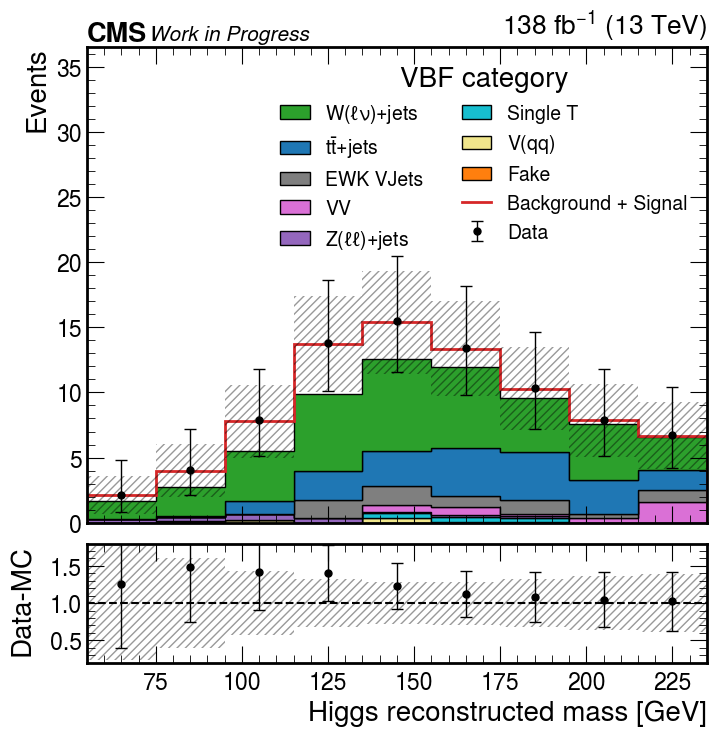

In [27]:
plot_(key="shapes_fit_s", region="SR1", mult=1)

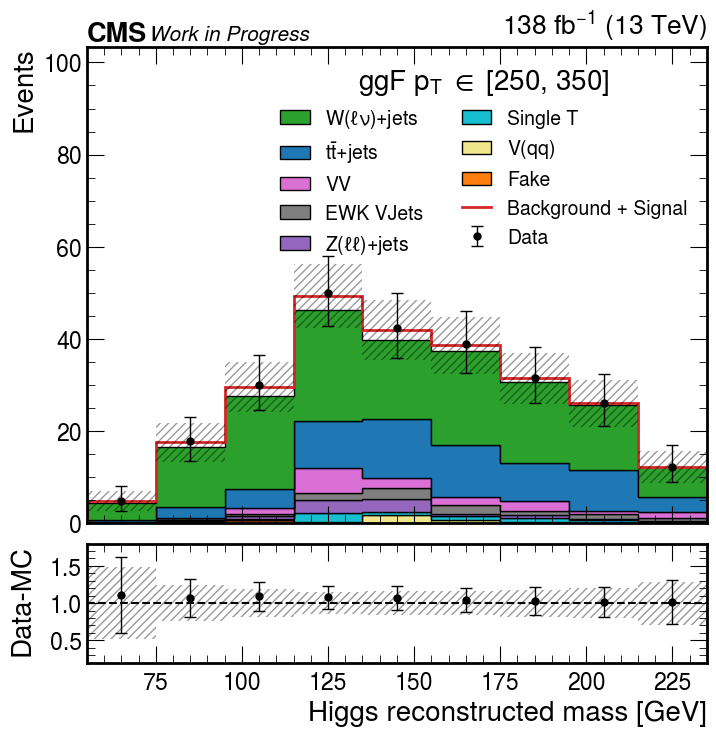

In [28]:
plot_(key="shapes_fit_s", region="SR2", mult=1)

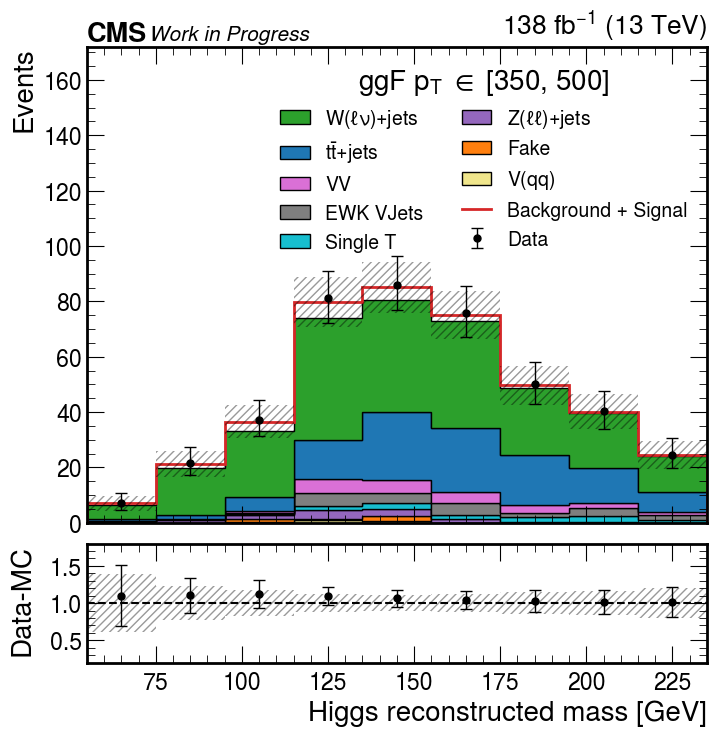

In [29]:
plot_(key="shapes_fit_s", region="SR3", mult=1)

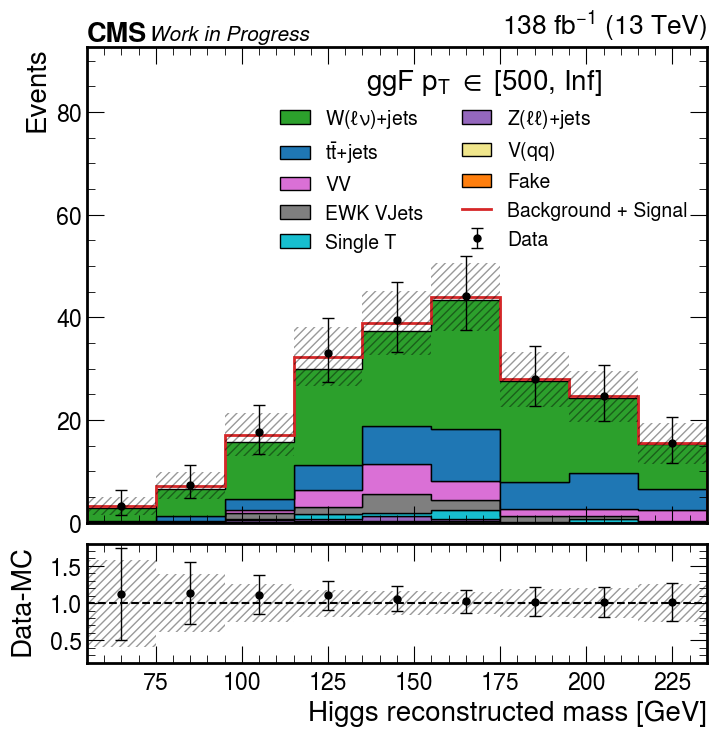

In [30]:
plot_(key="shapes_fit_s", region="SR4", mult=1)

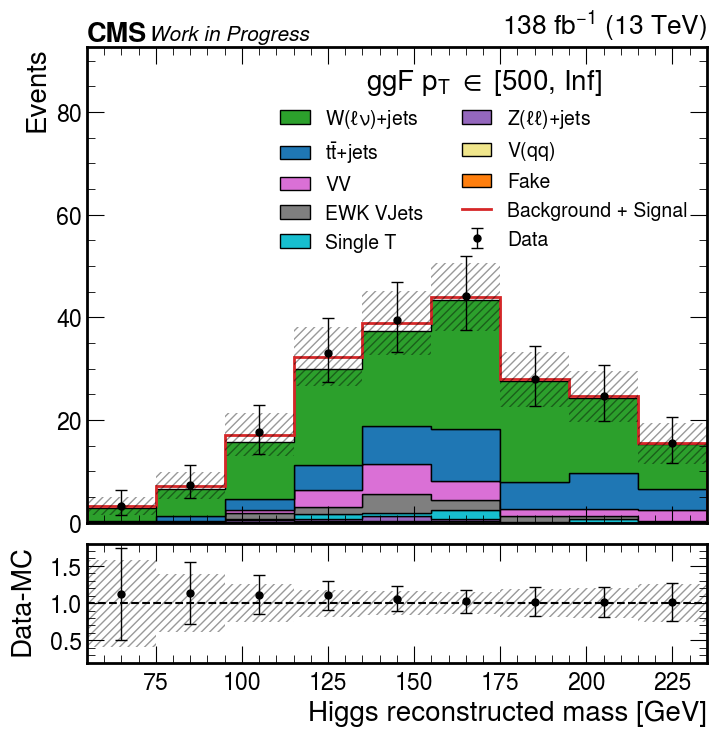

In [31]:
plot_(key="shapes_fit_s", region="SR4", mult=1)

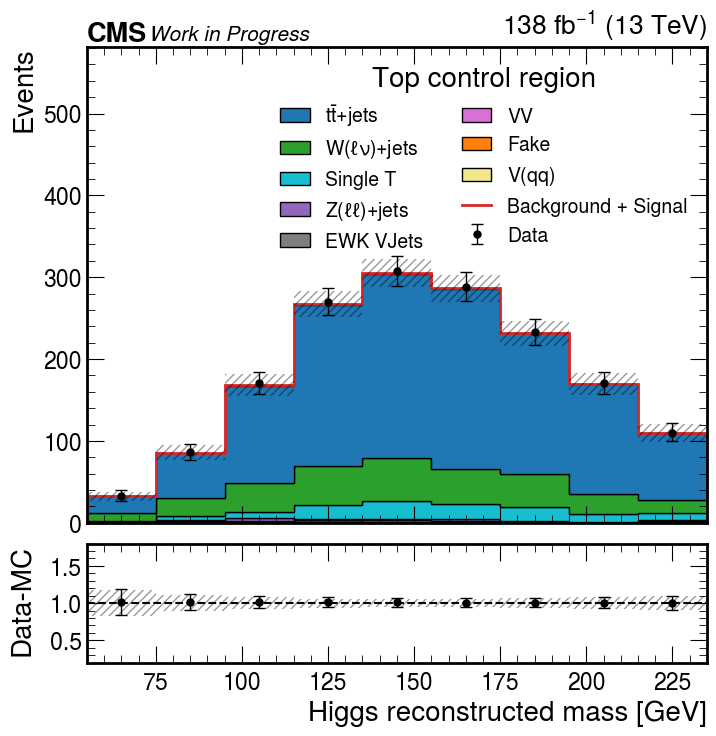

In [32]:
plot_(key="shapes_fit_s", region="CR1", mult=1)

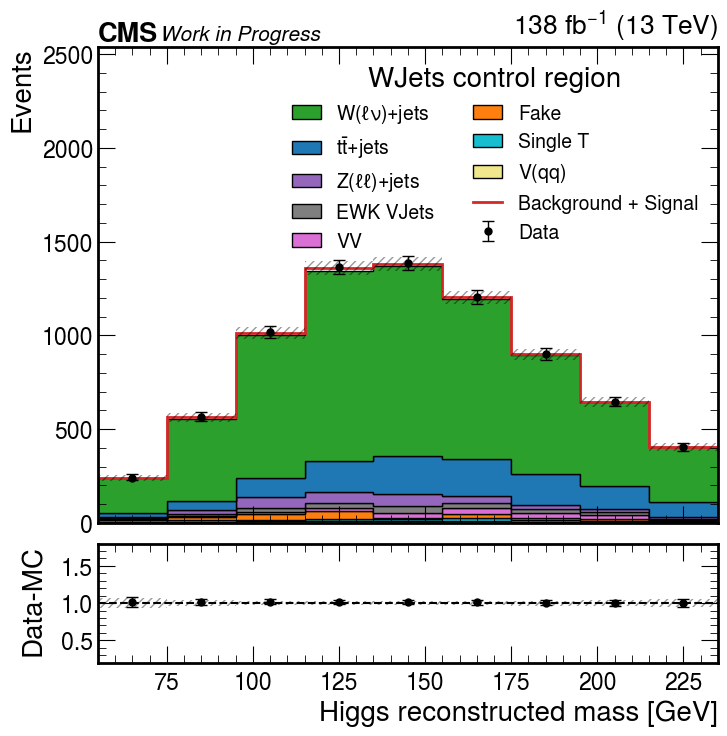

In [33]:
plot_(key="shapes_fit_s", region="CR2", mult=1)

In [31]:
massbinwidth = {
    "SR1": 20,
    "SR2": 20,
    "SR3": 20,
    "SR4": 20,
    "CR1": 20,
    "CR2": 20,
}

def plot_(key="shapes_fit_s", region="SR1", mult=1, add_back_MC=None):
    
    """
    add_back_MC: if None then won't add back MC. if True must be e.g. "v8" to get the nominal values.
    """

    if add_back_MC:
        # get lumi
        import pickle as pkl
        with open(f"../combine/templates/{add_back_MC}/hists_templates_Run2.pkl", "rb") as filename:    
            h = pkl.load(filename)

    ######################
    nbins = len(list(range(55, 255, massbinwidth[region])))-1
    samples = [samples_dict[sample[:-2]] for sample in f[f"{key}/{region}"].keys() if "total" not in sample]

    hf = hist2.Hist(
        hist2.axis.StrCategory(samples, name="Sample", growth=True),    
        hist2.axis.Regular(nbins, 55, 235, name="var", label=r"Higgs reconstructed mass [GeV]"),
        storage=hist2.storage.Weight(),
    )


    for sample in  f[f"{key}/{region}"].keys():
        if "total" in sample:
            continue
        
        smpl = samples_dict[sample[:-2]]
        if "data" in sample:    
            X = f[f"{key}/{region}"][sample].values()[1]*massbinwidth[region]
        else:
            X = f[f"{key}/{region}"][sample].values()*massbinwidth[region]
         
            if add_back_MC:
                # add MC back in the blinded region
                X[2:6] = h[region_dict_h[region]][{"Sample": smpl, "Systematic": "nominal"}].values()[2:6]

        print(smpl, X)
        
        hf.fill(Sample=smpl, var=X)
                
#         hf[{"Sample": smpl}] = X
#         print(X)
#         print("h", hf[{"Sample": samples_dict[sample[:-2]]}].values())
    plt.rcParams.update({"font.size": 20})
    add_data = True   # assumes it's Asimov

    years = ["2018", "2017", "2016", "2016APV"]
    channels = ["ele", "mu"]

    from utilsCombine2 import plot_hists
    print(hf)
    plot_hists(hf, years, channels,
                add_data=add_data,
                logy=False,
                add_soverb=False,
                only_sig=False,
                mult=mult,
                outpath=f"/Users/fmokhtar/Desktop/AN_2024/combine/",
               save_as=f"{key}_{region}",
               text_=region_dict[region],
               blind_region=False,
               remove_samples=["ttH", "WH", "ZH"]
              )

Data [ 1.97046375  4.15309668  7.52083874 13.17901611 13.97044945 13.11050892
  9.19427013  8.16674805  6.33260965]
VBF [0.36310405 0.98588574 1.5982461  2.5618255  1.7566803  1.092732
 0.5028122  0.18824112 0.09247296]
WH [0.00854359 0.02587159 0.03704556 0.05799292 0.04417222 0.0203805
 0.00900128 0.01161151 0.00538084]
ZH [0.00110264 0.00972807 0.01449875 0.02853392 0.02000785 0.00729956
 0.00352762 0.00476986 0.00253172]
Diboson [6.2259993e-08 6.2259993e-08 6.2259993e-08 6.2259993e-08 5.1005769e-01
 5.7270086e-01 1.8361774e-01 2.6941541e-01 1.5772080e+00]
EWKvjets [1.2323999e-07 1.2323999e-07 1.2323999e-07 1.4977686e+00 1.4487867e+00
 8.5116410e-01 1.0593082e+00 8.8309377e-01 4.2187834e-01]
Fake [3.3399998e-09 4.9199555e-02 9.9921576e-04 9.9921576e-04 9.9921576e-04
 9.9921576e-04 9.9921576e-04 9.9921576e-04 1.1180514e-01]
ggF [0.048193   0.36422884 0.43794376 0.7253213  0.50380266 0.22597982
 0.14358485 0.08499455 0.03195123]
SingleTop [1.9020000e-08 9.9990272e-04 1.9020000e-08 1.9

/Users/fmokhtar/miniconda3/envs/coffea-env/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


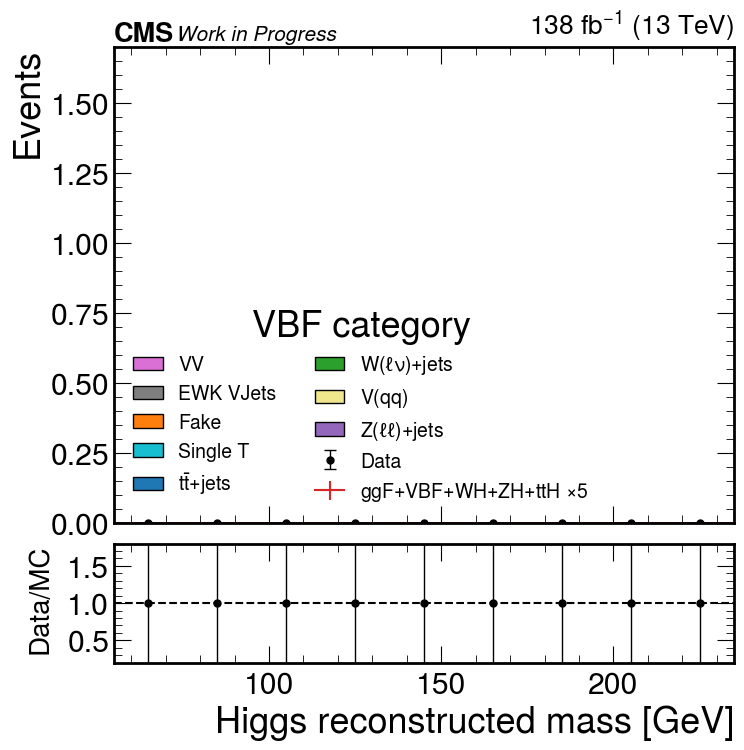

In [32]:
plot_(key="shapes_fit_s", region="SR1", mult=5, add_back_MC=add_back_MC)

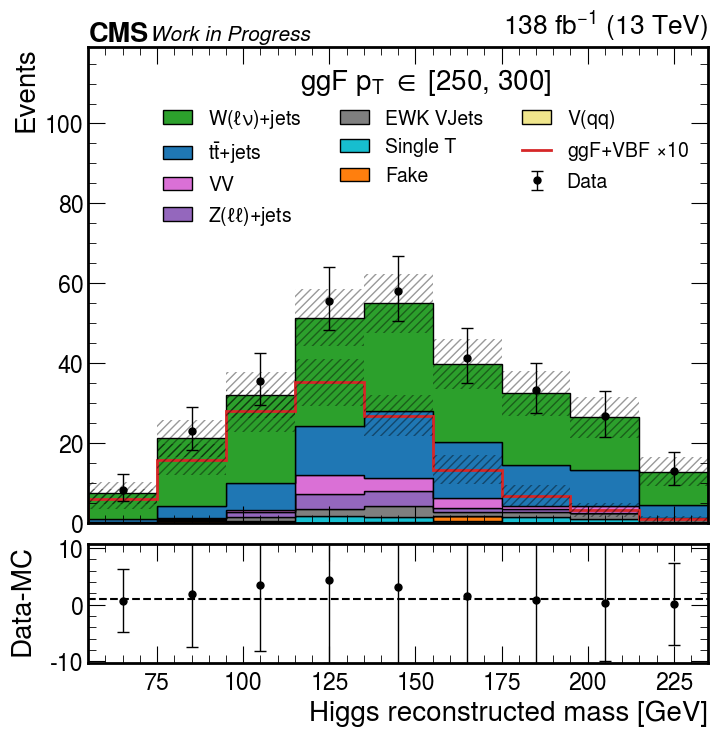

In [1023]:
plot_(key="shapes_fit_s", region="SR2", mult=10, add_back_MC=add_back_MC)

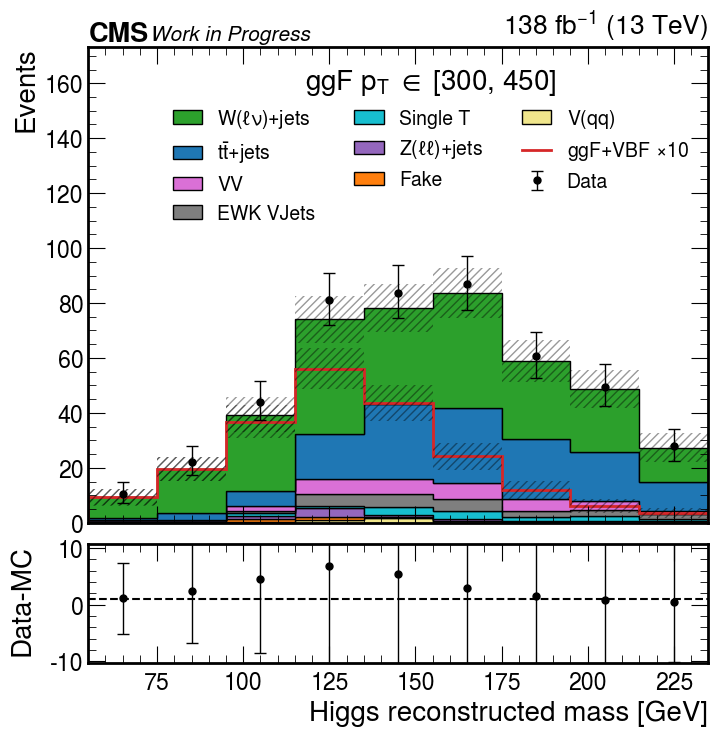

In [1024]:
plot_(key="shapes_fit_s", region="SR3", mult=10, add_back_MC=add_back_MC)

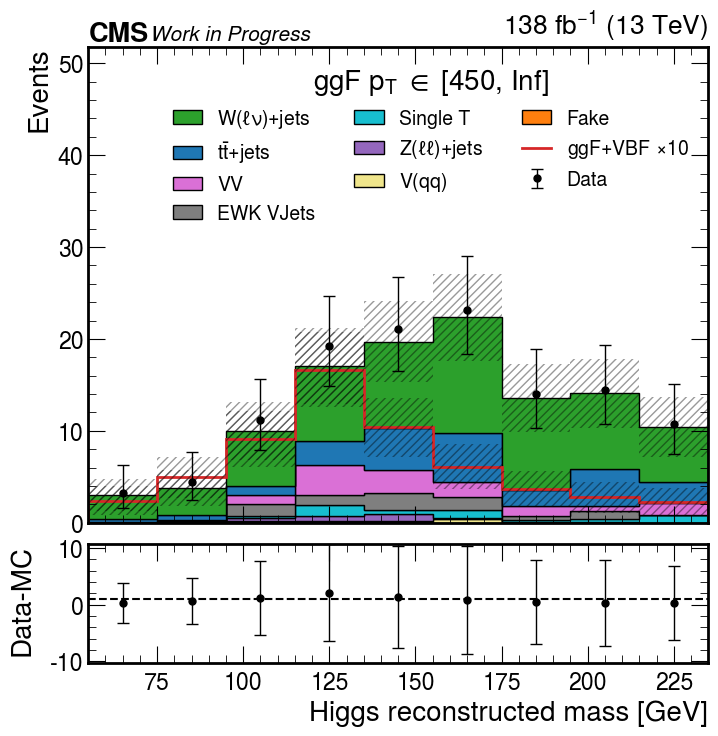

In [1025]:
plot_(key="shapes_fit_s", region="SR4", mult=10, add_back_MC=add_back_MC)

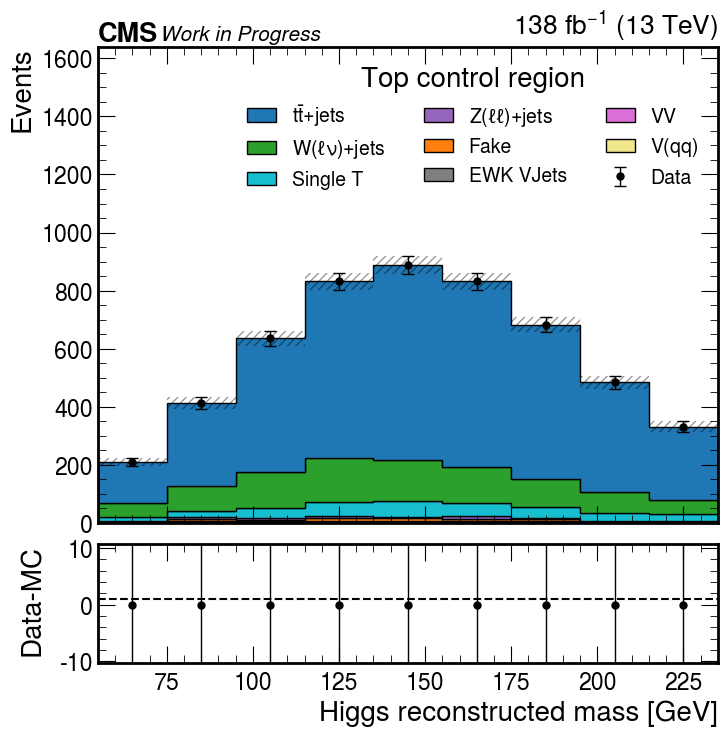

In [1026]:
plot_(key="shapes_fit_s", region="CR1", mult=1)

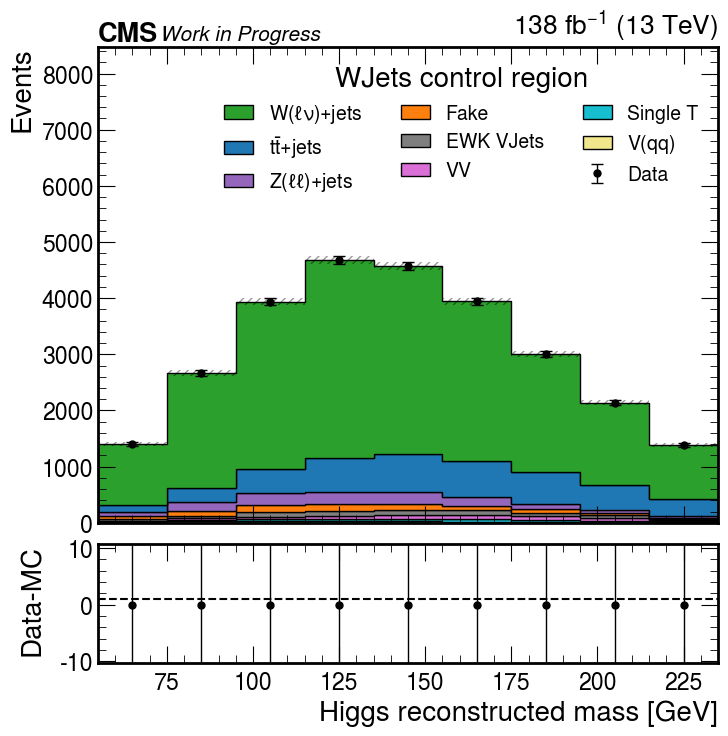

In [1027]:
plot_(key="shapes_fit_s", region="CR2", mult=1)